In [34]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import os
import ig2
import json
import visualization as vis
import colorcet as cc
from ig2 import REP_LAYER_VALUES, REP_DISTANCE_GRADIENTS
from base import INPUT_OUTPUT_GRADIENTS, CONVOLUTION_LAYER_VALUES, CONVOLUTION_OUTPUT_GRADIENTS, OUTPUT_LAYER_VALUES
cur_dir = os.getcwd()
device = 'cuda:4'

### Utility methods

In [35]:
def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images).to(device)
    return images.requires_grad_(True)


### Hook and Call_model_fuction for IG2

In [37]:
# Model load
model = models.inception_v3(pretrained=True, init_weights=False).to(device)
model.eval()
# Register hooks for Grad-CAM, which uses the last convolution layer
rep_layer = model.fc
rep_layer_outputs = {}

# Hook for representation
def rep_layer_forward(m, i, o):
    rep_layer_outputs[REP_LAYER_VALUES] = i[0]
forward_hook = rep_layer.register_forward_hook(rep_layer_forward)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    logits = model(images)
    if INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = logits[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.cpu().detach().numpy()
        return {INPUT_OUTPUT_GRADIENTS: gradients}

    elif REP_LAYER_VALUES in expected_keys:        
        return rep_layer_outputs

    # Gradient descent-based search for GradPath
    elif REP_DISTANCE_GRADIENTS in expected_keys:
        loss_fn = torch.nn.MSELoss()         
        baseline_conv = call_model_args['layer_baseline']
        input_conv = rep_layer_outputs[REP_LAYER_VALUES]
        
        loss = -1 * loss_fn(input_conv, baseline_conv)
        loss.backward()
        grads = images.grad.data
        grads = torch.movedim(grads, 1, 3)
        gradients = grads.cpu().detach().numpy()
        return {REP_DISTANCE_GRADIENTS: gradients,
                'loss':loss}

### Load Data

In [38]:
# In this example, we only use a few ImageNet samples, you can load the IamgeNet in your own way
with open(os.path.join('data/ImageNet/class_name_idx.json')) as fr:
    class_name_idx = json.load(fr)

def load_image():
    ims = {}
    for file_name in os.listdir(os.path.join('data/ImageNet')):
        if file_name.split('.')[1] != 'json':
            ims[file_name.split('.')[0]] = LoadImage(os.path.join('data/ImageNet',file_name))
    return ims
images = load_image()

### Load References
For general purpose, the references of IG2 can be randomly selected.

Predicted class: Doberman softmax:0.9587283134460449
['recreational vehicle', 'chimpanzee', 'acorn squash', 'tiger shark_1', 'basketball_4', 'fire engine_2', 'cheetah', 'fireboat']


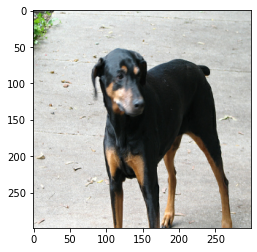

In [39]:
# Load the image
explicand_class = 'doberman'

im = images[explicand_class]
# Show the image
plt.imshow(im)
im = im.astype(np.float32)
im_tensor = PreprocessImages([im])
predictions = torch.nn.functional.softmax(model(im_tensor),dim=1)
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])
topk = np.argsort(predictions[0])[::-1]
call_model_args = {class_idx_str: prediction_class}

topname = str(class_name_idx[f'{topk[0]}'][1])
topname = topname.replace('_',' ')
print("Predicted class: " + topname + f' softmax:{predictions[0][topk[0]]}')

# Conterfactual refereces with different label to explicand
all_references = np.array([images[k] for k in images.keys() if k.split('_')[0] != topname])
all_references_classes = [k for i,k in enumerate(images.keys()) if k.split('_')[0] != topname]

n_reference = 8 # number of references, the attribution results will average on references
rnd_idx = np.random.choice(all_references.shape[0],replace=False, size=n_reference)
references = all_references[rnd_idx]
references_classes = [all_references_classes[i] for i in rnd_idx]
print(references_classes)

### IG2 attribution

In [40]:
explainer = ig2.IG2()
ig2_mask = explainer.GetMask(im,references,
    call_model_function,call_model_args,steps=201,step_size=256.0,clip_min_max=[0,255],)

GradPath search...


0 iterations, rep distance Loss -0.13892559707164764
100 iterations, rep distance Loss -0.012073151767253876
200 iterations, rep distance Loss -0.0075506120920181274
Integrate gradients on GradPath...


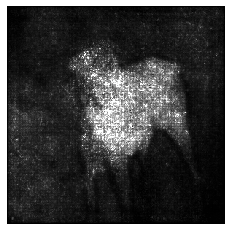

In [41]:
f, ax = plt.subplots()
vis.show_mask(vis.VisualizeImageGrayscale(ig2_mask), cmap=cc.cm.gray, axis=ax)

### With relevant reference (choice trick)

Using relevant reference can slightly improve results, by reducing noise.

The attributon results of ImageNet showed paper apply this trick.

Please see paper for detailed disccusion about the references. 

In [45]:
reference_class_list = []
for i in range(4):
    topname = str(class_name_idx[f'{topk[i]}'][1])
    topname = topname.replace('_',' ')
    print("Top"+ str(i) + "class: " + topname + f' softmax:{predictions[0][topk[i]]}')
    if i > 0:
        reference_class_list.append(topname)
references = np.array([images[k] for k in images.keys() if k.split('_')[0] in reference_class_list])
references_classes = [k for i,k in enumerate(images.keys()) if k.split('_')[0] in reference_class_list]
if len(references_classes) < 1:
    print("Relevant reference samples not found!")
else:   
    print(references_classes)

Top0class: Doberman softmax:0.9587283134460449
Top1class: miniature pinscher softmax:0.008956152945756912
Top2class: black-and-tan coonhound softmax:0.002410441404208541
Top3class: toy terrier softmax:0.0017647682689130306
['black-and-tan coonhound', 'toy terrier', 'miniature pinscher', 'toy terrier_1', 'black-and-tan coonhound_1']


GradPath search...
0 iterations, rep distance Loss -0.09006071090698242
100 iterations, rep distance Loss -0.004476806614547968
200 iterations, rep distance Loss -0.00286875176243484
Integrate gradients on GradPath...


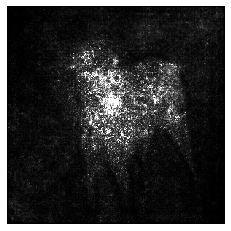

In [46]:
explainer = ig2.IG2()
ig2_mask = explainer.GetMask(im,references,
    call_model_function,call_model_args,steps=201,step_size=256.0,clip_min_max=[0,255],)
f, ax = plt.subplots()
vis.show_mask(vis.VisualizeImageGrayscale(ig2_mask), cmap=cc.cm.gray, axis=ax)